# Contents

### 0. Preliminary
    0.1 Import libraries
    0.2 Functions
    
### 1. Analyze
    1.1 Read csv
    1.2 How many NaN values
    1.3 Drop empty columns
    1.4 NaN volumetry plot
    1.5 List of qualitatives and quantitatives features
    1.6 New data frame with selected features

### 2. Clean Data Frame
    2.1 Drop energy-from-fat > energy
    2.2 Drop saturated-fat > fat
    2.3 Drop sugar > carbohydrates
    2.4 Drop duplicated
    2.5 Aberant values = NaN
    2.6 Unknown ==> NaN
    2.7 Check NaN volumetry

### 3. Replace NaN values
    3.1 Replace with similar features
        3.1.1 If energy is NaN: energy = energy-from-fat
        3.1.2 If fat is NaN: fat = saturated-fat
        3.1.3 If carbohydrates is NaN: carbohydrates = sugar
    3.2 Replace with zero
    3.3 Pnns group 1/2 median
    3.4 Sklearn methods
        3.4.1 StandardScaler
        3.4.2 Knn imputer
        3.4.3 Iterative imputer
        3.4.4 Simple Imputer
    3.5 Chose of the clened DataFrame
        3.5.1 Data dictionary
        3.5.2 Data_dictionary_droped incoplete (less then 95%) or eccessive (more the 105%) macronutrients.sum()
        3.5.3 Data  describe mean & median
        3.5.4 Data = data_simp_imp
### 4. Quartille outliers
    4.1 Quartille
    4.2 Plot outliers.sum() of every pnns groups 1&2
    4.3 Outliers to drop

## 0. Preliminary

### 0.1 Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
import seaborn as sns
import time

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import f_oneway, levene, bartlett


### 0.2 Functions

In [2]:
def nan_volumetry(df):
    """
    Plot a barh graph of NaN percentage values of every columns
    
    """
    n = len(df)
    m = n*(1/4)
    percentage_nan={}
    for i in df.columns:
        x = df[i].isna().sum()
        percentage = (x/n)*100
        percentage_nan[i] = percentage
        
    a = percentage_nan.keys()
    b = percentage_nan.values()
    percentage = pd.DataFrame({'columns':a,'%_NaN':b})
    percentage.sort_values('%_NaN', inplace=True)
    
    #PLOT

    plt.rcParams["figure.figsize"] =(10,len(percentage)/3)
    plt.figure()
    plt.title('NaN Percentage',fontsize=40, pad=40)
    plt.ylabel('Columns',fontsize = 20)
    plt.xlabel('% NaN', fontsize = 20)
    plt.barh(percentage['columns'],percentage['%_NaN'], label = percentage,color = 'r') 
    plt.margins(0.001)
    plt.grid(axis = 'x',linewidth=2, color = 'black')
    plt.xlim([0,100])
    plt.tick_params( length =15, labelsize=15)
    
    val = list(round(percentage['%_NaN'],4))
    for i in range(len(val)):
        plt.text(1/3,i-0.25,str(val[i])+'%', fontsize=15, color = 'black' )
    plt.savefig('NanVal',pad_inches=200, bbox_inches='tight')    
    plt.show()
    plt.close()

In [3]:
def check_size(df):
    
    """Check len of Data Frame"""
    
    print('CHECK SIZE OF DATAFRAME')
    print('number of elements : '+str(len(df)))

In [4]:
def drop_data_macronutrients_range(data,maximum_threshold=110,minimum_threshold=90):
    x = data.drop(index = ((data.loc[data.loc[:,macronutrients].sum(axis = 1) < minimum_threshold])).index)
    x.drop(index = ((x.loc[x.loc[:,macronutrients].sum(axis = 1) > maximum_threshold])).index , inplace=True )
    check_size(x)
    return x

In [5]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
   
            fig = plt.figure(figsize=(12,12))
        
            # points display
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend(bbox_to_anchor=(1, .5), loc = 'center left')

            # labels' points display
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # graph limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # abscissa and ordinate lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # axis' names, with explained percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} and F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [6]:
def data_describe_mean_median(data_dictionary,data_zero):
    """
    input: dictionary with the modified DataFrames and the original DataFrame 
    
    The function 

    """
    data_describe_mean={}
    data_describe_median={}
    for key, values in data_dictionary.items():
        data_describe_mean[key] = pd.DataFrame(((data_zero.describe())-(values.describe())).loc['mean']).rename(columns={'mean':key}).transpose()
        data_describe_median[key] = pd.DataFrame(((data_zero.describe())-(values.describe())).loc['50%']).rename(columns={'50%':key}).transpose()

    data_describe_mean= pd.concat(data_describe_mean.values())
    data_describe_median = pd.concat(data_describe_median.values())

    print('data_describe_mean')
    display(data_describe_mean)

    std_scaler = preprocessing.StandardScaler().fit(data_describe_mean)
    data_describe_mean_scaled = std_scaler.transform(data_describe_mean)
    data_describe_mean_scaled_abs = pd.DataFrame(data_describe_mean_scaled, index=data_dictionary.keys(),columns=quantitative_features).abs()

    print('data_describe_mean_scaled_abs')
    display(data_describe_mean_scaled_abs)

    print('data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1)')
    display(data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1))

    print('data_describe_median')
    display(data_describe_median)

    std_scaler = preprocessing.StandardScaler().fit(data_describe_median)
    data_describe_median_scaled = std_scaler.transform(data_describe_median)
    data_describe_median_scaled_abs = pd.DataFrame(data_describe_median_scaled, index=data_dictionary.keys(), columns=quantitative_features).abs()

    print('data_describe_median_scaled_abs')
    display(data_describe_median_scaled_abs)

    print('data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1)')
    display(data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1))


In [7]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # we display the 3 first factorial plane, i.e. the first 6 composants

        if d2 < n_comp:

            fig, ax = plt.subplots(figsize=(7,6))

            # graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # display arrows
            # do not show if more than 30
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # display variables names  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # plot cicle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # graphic lim
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # abscissa and ordinate lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # axis' names, with explained percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Circle of correlation (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

# 1. Analyze

### 1.1 Read CSV

In [8]:
%time df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)


#I will need to see all the columns
pd.set_option('display.max_columns', None)

CPU times: total: 17.9 s
Wall time: 18.2 s


In [9]:
df

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

### 1.2 How many NaN values

In [10]:
df.isna().sum().sum()
(a,b) = df.shape
# print(str(df.isna().sum().sum())+' out of '+str(a*b))
print(str(round(((df.isna().sum().sum())/(a*b))*100,2))+'% of nan values')


76.22% of nan values


### 1.3 Drop empty columns

In [11]:
print('size before:')
print(df.shape)

df.dropna(how='all', axis=1, inplace = True)

print('\nsize after:')
print(df.shape)

size before:
(320772, 162)

size after:
(320772, 146)


### 1.4 NaN volumetry plot

In [12]:
# nan_volumetry(df)

### 1.5 List of qualitatives and quantitatives features

In [13]:
x = df.columns.to_series().groupby(df.dtypes).groups
# x = df.columns.groupby(df.dtypes)
{k.name: v for k, v in x.items()}

{'float64': Index(['additives_n', 'ingredients_from_palm_oil_n',
        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g',
        'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
        'caprylic-acid_100g', 'capric-acid_100g', 'lauric-acid_100g',
        'myristic-acid_100g', 'palmitic-acid_100g', 'stearic-acid_100g',
        'arachidic-acid_100g', 'behenic-acid_100g', 'montanic-acid_100g',
        'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
        'omega-3-fat_100g', 'alpha-linolenic-acid_100g',
        'eicosapentaenoic-acid_100g', 'docosahexaenoic-acid_100g',
        'omega-6-fat_100g', 'linoleic-acid_100g', 'arachidonic-acid_100g',
        'gamma-linolenic-acid_100g', 'dihomo-gamma-linolenic-acid_100g',
        'omega-9-fat_100g', 'oleic-acid_100g', 'gondoic-acid_100g',
        'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
        'sugars_100g', 'sucrose_100g', 'glucose_100g', 'fructose_100g',
        'lactose_100g', 'maltose_100g', 'm

### 1.6 New data frame with selected features

In [14]:
index = ['code','product_name', 'generic_name']

macronutrients = ['fat_100g', 
                  'carbohydrates_100g', 
                  'fiber_100g', 
                  'proteins_100g', 
                  'salt_100g']
energy_macronutrients = ['energy_100g',
                         'fat_100g',
                         'carbohydrates_100g', 
                         'fiber_100g', 
                         'proteins_100g', 
                         'salt_100g']

quantitative_features = ['energy_100g', 
                         'energy-from-fat_100g', 
                         'fat_100g', 
                         'saturated-fat_100g', 
                         'cholesterol_100g', 
                         'carbohydrates_100g', 
                         'sugars_100g', 
                         'fiber_100g', 
                         'proteins_100g', 
                         'salt_100g']

qualitative_features = ['code',
                        'product_name', 
                        'generic_name', 
                        'pnns_groups_1', 
                        'pnns_groups_2']

quantitative_features_100 = ['fat_100g',
                             'saturated-fat_100g',
                             'cholesterol_100g',
                             'carbohydrates_100g',
                             'sugars_100g',
                             'fiber_100g',
                             'proteins_100g',
                             'salt_100g']

features = qualitative_features + quantitative_features

data = df.loc[:,features]

In [15]:
# nan_volumetry(data)

## 2. Clean Data Frame

### 2.1 Drop energy-from-fat > energy

In [16]:
data.drop(index = (data.loc[data['energy-from-fat_100g'] > data['energy_100g']]).index , inplace = True)

check_size(data)

CHECK SIZE OF DATAFRAME
number of elements : 320771


### 2.2 Drop saturated-fat > fat

In [17]:
data.drop(index = (data.loc[data['saturated-fat_100g'] > data['fat_100g']]).index , inplace = True)

check_size(data)

CHECK SIZE OF DATAFRAME
number of elements : 320417


### 2.3 Drop sugar > carbohydrates

In [18]:
data.drop(index = (data.loc[data['sugars_100g'] > data['carbohydrates_100g']]).index , inplace = True)

check_size(data)

CHECK SIZE OF DATAFRAME
number of elements : 319747


### 2.4 Drop duplicated

In [19]:
data.drop_duplicates(['product_name', 
                      'generic_name',
                      'energy_100g',
                      'energy-from-fat_100g', 
                      'fat_100g', 
                      'saturated-fat_100g', 
                      'cholesterol_100g', 
                      'carbohydrates_100g', 
                      'sugars_100g', 
                      'fiber_100g', 
                      'proteins_100g', 
                      'salt_100g'], inplace=True)


###  2.5 Aberant values = NaN

In [20]:
# NEGATIVES
for i in quantitative_features:
    data.loc[data[i]<0,i] = np.nan

# OUT OF RANGE

data.loc[data['energy_100g']>4200,'energy_100g'] = np.nan


data.loc[data['energy-from-fat_100g']>4200,'energy-from-fat_100g'] = np.nan

for i in quantitative_features: 
    if not i.startswith('energy'):
        data.loc[data[i]>100,i] = np.nan


### 2.6 Unknown ==> NaN

In [21]:
data.replace('unknown',np.nan,inplace=True)

### 2.7 Check NaN volumetry

In [22]:
# nan_volumetry(data)

## 3. Replace NaN values

### 3.1 Replace with similar features

#### 3.1.1 If energy is NaN: energy = energy-from-fat

In [23]:
index = ((data.loc[ data['energy_100g'].isna()]).loc[(data.loc[ data['energy_100g'].isna()]['energy-from-fat_100g']).isna() == False]).index

data.loc[index, 'energy_100g'] = data.loc[index, 'energy-from-fat_100g']

data.loc[index, 'energy_100g']

25066    262.0
Name: energy_100g, dtype: float64

In [24]:
data.drop(columns='energy-from-fat_100g', inplace=True)
quantitative_features.remove('energy-from-fat_100g')
features = qualitative_features + quantitative_features

#### 3.1.2  If fat is NaN: fat=saturated-fat

In [25]:
index = ((data.loc[ data['fat_100g'].isna()]).loc[(data.loc[ data['fat_100g'].isna()]['saturated-fat_100g']).isna() == False]).index

data.loc[index, 'fat_100g'] = data.loc[index, 'saturated-fat_100g']

data.loc[index, 'fat_100g']

190        0.80
191        2.90
234       11.00
307        1.70
456        8.60
          ...  
320698    10.00
320734     3.40
320740    12.00
320741     1.00
320757     3.73
Name: fat_100g, Length: 17281, dtype: float64

#### 3.1.3 If carbohydrates is NaN: carbohydrates=sugar

In [26]:
index = ((data.loc[ data['carbohydrates_100g'].isna()]).loc[(data.loc[ data['carbohydrates_100g'].isna()]['sugars_100g']).isna() == False]).index

data.loc[index, 'carbohydrates_100g'] = data.loc[index, 'sugars_100g']

data.loc[index, 'carbohydrates_100g']

190       87.70
191       50.30
234        1.00
307       12.70
456       41.20
          ...  
320698    22.00
320734     1.80
320740    10.50
320741     1.00
320757     3.89
Name: carbohydrates_100g, Length: 17516, dtype: float64

### 3.2 Replace with zero

##### If sum of macronutrients ~= 100 ==> fillna(0)

In [27]:
(data.loc[(data.loc[:,macronutrients].sum(axis = 1) <= 102.5)&(data.loc[:,macronutrients].sum(axis = 1) >= 97.5)]).fillna(0, inplace=True)


C:\Users\emanu\AppData\Local\Temp\ipykernel_4384\3902438679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (data.loc[(data.loc[:,macronutrients].sum(axis = 1) <= 102.5)&(data.loc[:,macronutrients].sum(axis = 1) >= 97.5)]).fillna(0, inplace=True)


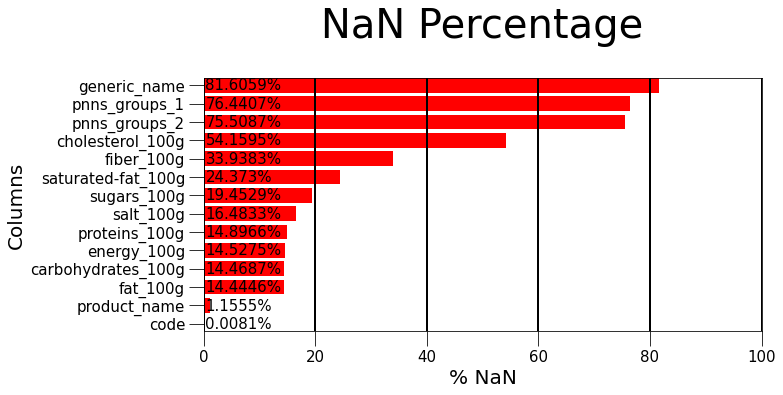

In [28]:
# nan_volumetry(data)

### 3.3 Pnns group 1/2 median

In [29]:
pnns_mean = data.groupby(['pnns_groups_1','pnns_groups_2']).mean()
ind =pnns_mean.index


for i in ind:    
    x = (data.loc[((data['pnns_groups_1']== i[0])&(data['pnns_groups_2'] == i[1]))]).fillna(pnns_mean.loc[i])
    data.loc[((data['pnns_groups_1']== i[0])&(data['pnns_groups_2'] == i[1]))] = x


In [30]:
data.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,253487.000000,253657.000000,229029.000000,193421.000000,253824.000000,242717.000000,220235.000000,252903.000000,250950.000000
mean,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.516920
std,778.805722,16.331639,7.712950,0.309983,28.550617,20.564164,4.271443,8.038328,5.788002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,389.000000,0.200000,0.000000,0.000000,5.360000,1.410000,0.000000,0.830000,0.083820
50%,1075.000000,5.000000,1.950000,0.002973,18.750000,5.830000,1.400000,4.900000,0.591820
75%,1668.000000,18.870000,7.140000,0.029241,56.670000,23.330000,3.600000,10.000000,1.374860
max,4197.000000,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000


In [31]:
# nan_volumetry(data)

### 3.4 Sklearn methods

#### 3.4.1 StandardScaler

In [32]:
n1 = len(data['pnns_groups_1'].drop_duplicates().tolist())
n2 = len(data['pnns_groups_2'].drop_duplicates().tolist())

X = data[quantitative_features].values
X = X.astype(np.float64)
std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)

#### 3.4.2 KNN imputer

In [33]:
# for saving the processing time
sklearn_time = {}

##### KNN X_scaled

In [34]:
#I saved the result in knn_X_scaled.csv

# tic = time.time() 
# imputer = KNNImputer(n_neighbors=n1)
# knn_X_scaled = pd.DataFrame(std_scaler.inverse_transform(imputer.fit_transform(X_scaled)))
# toc = time.time()
# sklearn_time['knn_X_scaled'] = toc-tic 
# print(str((toc-tic)/60)+' min')

# knn_X_scaled.to_csv('knn_X_scaled.csv', index=False)
# time: 53min 40s

In [35]:
knn_X_scaled = pd.read_csv("knn_X_scaled.csv")

In [36]:
knn_X_scaled.describe()

,0,1,2,3,4,5,6,7,8
count,282292.000000,282292.000000,2.822920e+05,2.822920e+05,282292.000000,282292.000000,282292.000000,282292.000000,2.822920e+05
mean,1113.568744,12.009183,4.669696e+00,2.161922e-02,30.549636,15.286008,2.506348,7.129714,1.521302e+00
std,738.997733,15.488456,7.114681e+00,2.621109e-01,27.086443,19.381381,3.885009,7.620609,5.480300e+00
min,0.000000,0.000000,0.000000e+00,-3.469447e-18,0.000000,0.000000,0.000000,0.000000,-2.220446e-16
25%,440.000000,0.500000,8.881784e-16,-3.469447e-18,6.670000,1.574480,0.000000,1.300000,1.041400e-01
50%,1114.465419,7.300000,2.110000e+00,4.000000e-03,25.000000,7.500000,1.600000,6.000000,7.518400e-01
75%,1611.000000,17.000000,5.476250e+00,2.268503e-02,53.000000,19.350000,3.050508,9.300000,1.516920e+00
max,4197.000000,100.000000,1.000000e+02,9.523800e+01,100.000000,100.000000,100.000000,100.000000,1.000000e+02


In [37]:
knn_X_scaled

,0,1,2,3,4,5,6,7,8
0,1114.465419,12.022121,5.064155e+00,2.268503e-02,30.562035,15.625957,2.693023,7.138156,1.516920
1,2243.000000,28.570000,2.857000e+01,1.800000e-02,64.290000,14.290000,3.600000,3.570000,0.000000
2,1941.000000,17.860000,0.000000e+00,-3.469447e-18,60.710000,17.860000,7.100000,17.860000,0.635000
3,2540.000000,57.140000,5.360000e+00,3.469447e-18,17.860000,3.570000,7.100000,17.860000,1.224280
4,1552.000000,1.430000,2.714286e-01,5.011521e-04,77.140000,8.592857,5.700000,8.570000,0.586389
...,...,...,...,...,...,...,...,...,...
282287,1114.465419,12.022121,5.064155e+00,2.268503e-02,30.562035,15.625957,2.693023,7.138156,1.516920
282288,0.000000,0.000000,0.000000e+00,-3.469447e-18,0.000000,0.000000,0.000000,0.000000,0.000000
282289,2017.370858,25.295682,5.162642e+00,4.955368e-03,51.950262,4.069929,4.067025,7.806740,1.761810
282290,1114.465419,12.022121,5.064155e+00,2.268503e-02,30.562035,15.625957,2.693023,7.138156,1.516920


In [38]:
data_knn_X_scaled = data.reset_index()[features]
for i in range(len(quantitative_features)):
    data_knn_X_scaled[quantitative_features[i]].fillna(value=knn_X_scaled.iloc[:,i], inplace=True)

In [39]:
print('data_knn_X_scaled.describe()')
display(data_knn_X_scaled.describe())

(data.describe()-data_knn_X_scaled.describe()).abs()

data_knn_X_scaled.describe()


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,282292.000000,282292.000000,2.822920e+05,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,2.822920e+05
mean,1113.568744,12.009183,4.669696e+00,0.021619,30.549636,15.286008,2.506348,7.129714,1.521302e+00
std,738.997733,15.488456,7.114681e+00,0.262111,27.086443,19.381381,3.885009,7.620609,5.480300e+00
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-2.220446e-16
25%,440.000000,0.500000,8.881784e-16,0.000000,6.670000,1.574480,0.000000,1.300000,1.041400e-01
50%,1114.465419,7.300000,2.110000e+00,0.004000,25.000000,7.500000,1.600000,6.000000,7.518400e-01
75%,1611.000000,17.000000,5.476250e+00,0.022685,53.000000,19.350000,3.050508,9.300000,1.516920e+00
max,4197.000000,100.000000,1.000000e+02,95.238000,100.000000,100.000000,100.000000,100.000000,1.000000e+02


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,28805.000000,28635.000000,5.326300e+04,88871.000000,28468.000000,39575.000000,62057.000000,29389.000000,3.134200e+04
mean,0.896675,0.012938,3.944591e-01,0.001066,0.012399,0.339949,0.186675,0.008442,4.381985e-03
std,39.807989,0.843183,5.982688e-01,0.047872,1.464174,1.182782,0.386434,0.417719,3.077017e-01
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.220446e-16
25%,51.000000,0.300000,8.881784e-16,0.000000,1.310000,0.164480,0.000000,0.470000,2.032000e-02
50%,39.465419,2.300000,1.600000e-01,0.001027,6.250000,1.670000,0.200000,1.100000,1.600200e-01
75%,57.000000,1.870000,1.663750e+00,0.006556,3.670000,3.980000,0.549492,0.700000,1.420601e-01
max,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


##### KNN X

In [40]:
# #I saved the result in knn_X.csv

# tic = time.time()

# imputer = KNNImputer(n_neighbors=n1)
# knn_X = pd.DataFrame(imputer.fit_transform(X))

# toc = time.time()
# sklearn_time['knn_X'] = toc-tic 
# print(str((toc-tic)/60)+' min')

# knn_X.to_csv('knn_X.csv',index=False)


In [41]:
knn_X = pd.read_csv("knn_X.csv")

In [42]:
knn_X

,0,1,2,3,4,5,6,7,8
0,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.516920
1,2243.000000,28.570000,28.570000,0.018000,64.290000,14.290000,3.600000,3.570000,0.000000
2,1941.000000,17.860000,0.000000,0.000000,60.710000,17.860000,7.100000,17.860000,0.635000
3,2540.000000,57.140000,5.360000,0.000000,17.860000,3.570000,7.100000,17.860000,1.224280
4,1552.000000,1.430000,0.350000,0.000200,77.140000,12.462857,5.700000,8.570000,0.777937
...,...,...,...,...,...,...,...,...,...
282287,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.516920
282288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
282289,2017.370858,25.295682,5.162642,0.004955,51.950262,4.069929,4.067025,7.806740,1.761810
282290,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.516920


In [43]:
knn_X.describe()

,0,1,2,3,4,5,6,7,8
count,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000
mean,1113.669493,12.011834,4.668304,0.021233,30.550374,15.267944,2.507623,7.130957,1.516700
std,738.910750,15.487320,7.106845,0.257656,27.086236,19.351572,3.873171,7.620781,5.469794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,441.000000,0.500000,0.000000,0.000000,6.670000,1.574480,0.000000,1.300000,0.104140
50%,1114.465419,7.300000,2.120000,0.004955,25.000000,7.500000,1.600000,6.000000,0.750000
75%,1611.000000,17.000000,5.478393,0.022685,53.000000,19.300000,3.050508,9.300000,1.516920
max,4197.000000,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000


In [44]:
data_knn_X = data.reset_index()[features]
for i in range(len(quantitative_features)):
    data_knn_X[quantitative_features[i]].fillna(value=knn_X.iloc[:,i], inplace=True)

In [45]:
print('data_knn_X.describe()')
display(data_knn_X.describe())

data_knn_X.describe()-data.describe()

data_knn_X.describe()


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000
mean,1113.669493,12.011834,4.668304,0.021233,30.550374,15.267944,2.507623,7.130957,1.516700
std,738.910750,15.487320,7.106845,0.257656,27.086236,19.351572,3.873171,7.620781,5.469794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,441.000000,0.500000,0.000000,0.000000,6.670000,1.574480,0.000000,1.300000,0.104140
50%,1114.465419,7.300000,2.120000,0.004955,25.000000,7.500000,1.600000,6.000000,0.750000
75%,1611.000000,17.000000,5.478393,0.022685,53.000000,19.300000,3.050508,9.300000,1.516920
max,4197.000000,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,28805.000000,28635.000000,53263.000000,88871.000000,28468.000000,39575.000000,62057.000000,29389.000000,31342.000000
mean,-0.795926,-0.010288,-0.395851,-0.001452,-0.011661,-0.358013,-0.185400,-0.007199,-0.000220
std,-39.894972,-0.844319,-0.606105,-0.052327,-1.464381,-1.212591,-0.398272,-0.417547,-0.318208
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.000000,0.300000,0.000000,0.000000,1.310000,0.164480,0.000000,0.470000,0.020320
50%,39.465419,2.300000,0.170000,0.001982,6.250000,1.670000,0.200000,1.100000,0.158180
75%,-57.000000,-1.870000,-1.661607,-0.006556,-3.670000,-4.030000,-0.549492,-0.700000,0.142060
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### 3.4.3 Iterative imputer

In [46]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# tic = time.time()
# ite_imp_mean = IterativeImputer(initial_strategy='median', random_state=0 , max_iter=20, min_value=0 )
# ite_imp = pd.DataFrame(std_scaler.inverse_transform(ite_imp_mean.fit_transform(X_scaled)))
# toc = time.time()
# sklearn_time['ite_imp'] = (toc-tic)/60 
# print(str((toc-tic)/60)+' min')

# ite_imp.to_csv('ite_imp.csv',index=False)


In [47]:
ite_imp = pd.read_csv("ite_imp.csv")

In [49]:
data_ite_imp = data.reset_index()[features]
for i in range(len(quantitative_features)):
    data_ite_imp[quantitative_features[i]].fillna(value=ite_imp.iloc[:,i], inplace=True)

In [50]:
data_ite_imp.describe()

,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
count,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000,282292.000000
mean,1115.512559,12.025690,5.087675,0.024352,30.570702,15.765841,2.721027,7.145461,1.519544
std,738.992663,15.483127,6.963545,0.256745,27.077187,19.149777,3.780224,7.611410,5.457358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,444.000000,0.500000,0.200000,0.000000,6.670000,2.000000,0.251154,1.400000,0.109220
50%,1114.465419,7.400000,3.570000,0.022685,25.000000,9.000000,2.400000,6.000000,0.770000
75%,1611.000000,17.000000,5.560000,0.024427,53.000000,20.000000,3.100000,9.300000,1.517206
max,5931.354794,100.000000,100.000000,95.238000,100.000000,100.000000,100.000000,100.000000,100.000000


#### 3.4.4 Simple Imputer

In [ ]:

# tic = time.time()
# simp_imp_mean = SimpleImputer()
# simp_imp= pd.DataFrame(simp_imp_mean.fit_transform(X))
# toc = time.time()
# sklearn_time['simp_imp'] = (toc-tic)/60 
# print(str((toc-tic)/60)+' min')

# simp_imp.to_csv('simp_imp.csv',index=False)


In [51]:
simp_imp = pd.read_csv("simp_imp.csv")

In [53]:
data_simp_imp = data.reset_index()[features]
# data_simp_imp = data_simp_imp[features]
display(data_simp_imp)
for i in range(len(quantitative_features)):
    data_simp_imp[quantitative_features[i]].fillna(value=simp_imp.iloc[:,i], inplace=True)

,code,product_name,generic_name,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,NaN,2243.000000,28.570000,28.570000,0.018000,64.290000,14.290000,3.600000,3.57000,0.00000
2,0000000004559,Peanuts,NaN,NaN,NaN,1941.000000,17.860000,0.000000,0.000000,60.710000,17.860000,7.100000,17.86000,0.63500
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,NaN,2540.000000,57.140000,5.360000,NaN,17.860000,3.570000,7.100000,17.86000,1.22428
4,0000000016094,Organic Polenta,NaN,NaN,NaN,1552.000000,1.430000,NaN,NaN,77.140000,NaN,5.700000,8.57000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282287,9948282780603,Tomato & ricotta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282288,99567453,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
282289,9970229501521,乐吧泡菜味薯片,Leba pickle flavor potato chips,Salty snacks,Appetizers,2017.370858,25.295682,5.162642,0.004955,51.950262,4.069929,4.067025,7.80674,1.76181
282290,9980282863788,Tomates aux Vermicelles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_simp_imp.describe()
data_simp_imp

,code,product_name,generic_name,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,0000000003087,Farine de blé noir,NaN,NaN,NaN,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.51692
1,0000000004530,Banana Chips Sweetened (Whole),NaN,NaN,NaN,2243.000000,28.570000,28.570000,0.018000,64.290000,14.290000,3.600000,3.570000,0.00000
2,0000000004559,Peanuts,NaN,NaN,NaN,1941.000000,17.860000,0.000000,0.000000,60.710000,17.860000,7.100000,17.860000,0.63500
3,0000000016087,Organic Salted Nut Mix,NaN,NaN,NaN,2540.000000,57.140000,5.360000,0.022685,17.860000,3.570000,7.100000,17.860000,1.22428
4,0000000016094,Organic Polenta,NaN,NaN,NaN,1552.000000,1.430000,5.064155,0.022685,77.140000,15.625957,5.700000,8.570000,1.51692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282287,9948282780603,Tomato & ricotta,NaN,NaN,NaN,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.51692
282288,99567453,"Mint Melange Tea A Blend Of Peppermint, Lemon ...",NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
282289,9970229501521,乐吧泡菜味薯片,Leba pickle flavor potato chips,Salty snacks,Appetizers,2017.370858,25.295682,5.162642,0.004955,51.950262,4.069929,4.067025,7.806740,1.76181
282290,9980282863788,Tomates aux Vermicelles,NaN,NaN,NaN,1114.465419,12.022121,5.064155,0.022685,30.562035,15.625957,2.693023,7.138156,1.51692


##### sklearn_time

In [ ]:
# sklearn_time

### 3.5 Chose of the clened DataFrame

#### 3.5.1 Data dictionary

In [55]:
data_dictionary={}
data_dictionary['data_knn_X_scaled'] = data_knn_X_scaled
data_dictionary['data_knn_X'] = data_knn_X
data_dictionary['data_ite_imp'] = data_ite_imp
data_dictionary['data_simp_imp'] = data_simp_imp
data_old = pd.DataFrame(data)

##### Write to csv

In [56]:
data_old.to_csv('data_old.csv', index=False)

#### 3.5.2 Data dictionary droped incoplete (less then 95%) or eccessive (more the 105%) macronutrients.sum()

In [57]:
data_dictionary_droped = {}
for key,value in data_dictionary.items():
    print('\ndrop_data_macronutrients_range('+key+'_droped):')
    data_dictionary_droped[key+'_droped'] = drop_data_macronutrients_range(value)

    
print('\ndrop_data_macronutrients_range(data)')
data_droped = drop_data_macronutrients_range(data)


drop_data_macronutrients_range(data_knn_X_scaled_droped):
CHECK SIZE OF DATAFRAME
number of elements : 61847

drop_data_macronutrients_range(data_knn_X_droped):
CHECK SIZE OF DATAFRAME
number of elements : 61823

drop_data_macronutrients_range(data_ite_imp_droped):
CHECK SIZE OF DATAFRAME
number of elements : 62221

drop_data_macronutrients_range(data_simp_imp_droped):
CHECK SIZE OF DATAFRAME
number of elements : 61940

drop_data_macronutrients_range(data)
CHECK SIZE OF DATAFRAME
number of elements : 60993


##### Write  to csv

In [58]:
for key in data_dictionary_droped.keys():
    data_dictionary_droped[key].to_csv(key+'.csv', index=False)
data_droped.to_csv('data_droped.csv', index=False)

#### 3.5.3 Data  describe mean & median

In [59]:
data_describe_mean_median(data_dictionary, data_old)

data_describe_mean


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled,8.966750e-01,1.293830e-02,3.944591e-01,1.065809e-03,1.239906e-02,3.399495e-01,1.866752e-01,8.441628e-03,-4.381985e-03
data_knn_X,7.959261e-01,1.028784e-02,3.958510e-01,1.452035e-03,1.166080e-02,3.580134e-01,1.854004e-01,7.199175e-03,2.198744e-04
data_ite_imp,-1.047140e+00,-3.568533e-03,-2.351983e-02,-1.666679e-03,-8.666548e-03,-1.398835e-01,-2.800383e-02,-7.305144e-03,-2.623944e-03
data_simp_imp,1.182116e-09,-7.972289e-12,5.547562e-12,-3.642225e-14,-4.168399e-11,-5.471179e-13,-2.920775e-12,5.240253e-13,2.251976e-12


data_describe_mean_scaled_abs


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled,0.943428,1.166170,0.995745,0.705899,0.978295,0.930864,1.001468,1.008134,1.404554
data_knn_X,0.814163,0.780960,1.002581,1.025513,0.893830,1.014759,0.988784,0.811120,1.002308
data_ite_imp,1.550554,1.232885,1.056915,1.555320,1.431835,1.297645,1.134435,1.488811,0.485064
data_simp_imp,0.207037,0.714245,0.941411,0.176091,0.440290,0.647978,0.855817,0.330444,0.887310


data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1)


data_knn_X_scaled    6.502049
data_knn_X           5.291166
data_ite_imp         7.323584
data_simp_imp        3.435142
dtype: float64

data_describe_median


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled,-39.465419,-2.3,-0.16,-0.001027,-6.25,-1.67,-0.2,-1.1,-0.16002
data_knn_X,-39.465419,-2.3,-0.17,-0.001982,-6.25,-1.67,-0.2,-1.1,-0.15818
data_ite_imp,-39.465419,-2.4,-1.62,-0.019712,-6.25,-3.17,-1.0,-1.1,-0.17818
data_simp_imp,-39.465419,-2.4,-1.62,-0.019712,-6.25,-3.17,-1.0,-1.1,-0.17818


data_describe_median_scaled_abs


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled,1.732051,1.0,1.006861,1.051748,0.0,1.0,1.0,0.0,0.901470
data_knn_X,0.577350,1.0,0.993115,0.946877,0.0,1.0,1.0,0.0,1.093896
data_ite_imp,0.577350,1.0,0.999988,0.999312,0.0,1.0,1.0,0.0,0.997683
data_simp_imp,0.577350,1.0,0.999988,0.999312,0.0,1.0,1.0,0.0,0.997683


data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1)


data_knn_X_scaled    4.633521
data_knn_X           3.671246
data_ite_imp         3.575033
data_simp_imp        3.575033
dtype: float64

In [60]:
data_describe_mean_median(data_dictionary_droped, data_droped)

data_describe_mean


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled_droped,3.734796,0.122546,0.380616,-0.001174,0.083882,0.519576,0.286354,0.003910,-0.016339
data_knn_X_droped,3.457381,0.104734,0.382274,-0.000397,0.099203,0.561245,0.277832,0.002706,-0.016514
data_ite_imp_droped,8.457727,0.317341,0.175119,-0.002558,-0.137213,-0.112187,0.151543,0.055764,-0.039327
data_simp_imp_droped,9.656012,0.270221,0.192557,-0.001273,-0.132403,0.183339,0.223041,0.064956,-0.040041


data_describe_mean_scaled_abs


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled_droped,0.937384,0.884006,0.989667,0.227554,0.931141,0.846476,0.960182,0.972501,1.007253
data_knn_X_droped,1.037722,1.078006,1.006416,1.229964,1.066347,0.998785,0.801785,1.014428,0.992247
data_ite_imp_droped,0.770850,1.237610,1.086112,1.557381,1.019968,1.462729,1.545411,0.833414,0.969037
data_simp_imp_droped,1.204257,0.724402,0.909970,0.099863,0.977520,0.382532,0.216557,1.153515,1.030463


data_describe_mean_scaled_abs[energy_macronutrients].sum(axis=1)


data_knn_X_scaled_droped    5.692468
data_knn_X_droped           5.990535
data_ite_imp_droped         6.376290
data_simp_imp_droped        5.306714
dtype: float64

data_describe_median


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled_droped,0.0,0.24,0.360000,0.0,0.05,0.81,0.0,0.0,0.00038
data_knn_X_droped,0.0,0.19,0.360000,0.0,0.05,0.89,0.0,0.0,-0.00254
data_ite_imp_droped,6.0,0.69,0.295845,0.0,-0.26,0.17,0.0,0.0,-0.00762
data_simp_imp_droped,6.0,0.69,0.295845,0.0,-0.26,1.81,0.0,0.0,-0.00762


data_describe_median_scaled_abs


,energy_100g,fat_100g,saturated-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
data_knn_X_scaled_droped,1.0,0.892269,1.0,0.0,1.0,0.188124,0.0,0.0,1.379372
data_knn_X_droped,1.0,1.102214,1.0,0.0,1.0,0.051306,0.0,0.0,0.527836
data_ite_imp_droped,1.0,0.997241,1.0,0.0,1.0,1.282660,0.0,0.0,0.953604
data_simp_imp_droped,1.0,0.997241,1.0,0.0,1.0,1.522090,0.0,0.0,0.953604


data_describe_median_scaled_abs[energy_macronutrients].sum(axis=1)


data_knn_X_scaled_droped    4.271641
data_knn_X_droped           3.630050
data_ite_imp_droped         3.950845
data_simp_imp_droped        3.950845
dtype: float64

#### 3.5.4 Data = data_simp_imp_droped

In [ ]:
data = data_dictionary_droped['data_simp_imp_droped']

## 4. Quartille outliers

### 4.1 Quartille

In [ ]:
data_group = (data.groupby(['pnns_groups_1','pnns_groups_2']).mean()).index
outliers_dic={}

for i in data_group:
    for j in quantitative_features:
        x = (data.loc[((data['pnns_groups_1']== i[0])&(data['pnns_groups_2'] == i[1]))])[j]
        
        Q3 = np.quantile(x , 0.75)
        Q1 = np.quantile(x , 0.25)
        IQR = Q3 - Q1
        ul = Q3+1.5*IQR
        ll = Q1-1.5*IQR
        outliers = x[(x > ul) | (x < ll)]
        outliers_dic[i+(j,)]= outliers

### 4.2 Plot outliers.sum() of every pnns groups 1&2

In [ ]:
outliers_df = pd.DataFrame(data ={'tot_outliers' : [len(outliers_dic[i]) for i in outliers_dic.keys()],
                                  'pnns_names' : [i[0]+', '+i[1]+', '+i[2] for i in outliers_dic.keys()] }, 
                           index = outliers_dic.keys()
                          ) 
outliers_df.sort_values(by = 'tot_outliers')

#PLOT
t = outliers_df.sort_values(by = 'tot_outliers',ascending=False)
x = t.loc[t['tot_outliers']>150,'tot_outliers']
y = t.loc[t['tot_outliers']>150,'pnns_names']

plt.rcParams["figure.figsize"] =(10,len(x)/3)
plt.figure()
plt.title('Number of Outliers for pnns group',fontsize=40, pad=40)
plt.ylabel('pnns names',fontsize = 20)
plt.xlabel("# outliers", fontsize = 20)
plt.barh(y, x, color = 'yellow') 
plt.margins(0.001)
plt.grid(axis = 'x',linewidth=2, color = 'black')
# plt.xlim([0,100])
plt.tick_params( length =15, labelsize=15)

val = list(x)
for i in range(len(val)):
    plt.text(1/3,i-0.25,str(val[i]), fontsize=15, color = 'black' )
    
plt.show()
plt.close()

### 4.3 Products with more outliers elements

In [ ]:
outliers_data = pd.DataFrame.from_dict(outliers_dic,orient='index')
outliers_2 = outliers_data.loc[:,outliers_data.notna().sum()>=2]
outliers_3 = outliers_data.loc[:,outliers_data.notna().sum()>=3]
outliers_4 = outliers_data.loc[:,outliers_data.notna().sum()>=4]
outliers_5 = outliers_data.loc[:,outliers_data.notna().sum()>=5]
outliers_6 = outliers_data.loc[:,outliers_data.notna().sum()>=6]
outliers_7 = outliers_data.loc[:,outliers_data.notna().sum()>=7]
outliers_8 = outliers_data.loc[:,outliers_data.notna().sum()>=8]
outliers_9 = outliers_data.loc[:,outliers_data.notna().sum()>=9]


#PLOT 
x = outliers_7.notna().sum().sort_values().values                      #Abscissa
y = [str(data.loc[i]['code'])+': \n'
     +str(data.loc[i]['product_name'])+'; '
     +str(data.loc[i]['pnns_groups_1'])+'; '
     +str(data.loc[i]['pnns_groups_2'])+'.' 
     for i in outliers_7.notna().sum().sort_values().index]     #Ordinate

plt.rcParams["figure.figsize"] =(10,len(x)/1.5)
plt.figure()
plt.title('Products with more outliers elements',fontsize=40, pad=40)
plt.ylabel('pnns codes & names',fontsize = 20)
plt.xlabel("# outliers", fontsize = 20)
plt.barh(y, x, color = 'yellow') 
plt.margins(0.001)
plt.grid(axis = 'x',linewidth=2, color = 'black')
plt.tick_params( length =15, labelsize=15)

for i in range(len(x)):
    plt.text(1/1.5,i-0.25,str(x[i]), fontsize=15, color = 'black' )  
plt.show()
plt.close()